In [1]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from IPython import display
from sam2.build_sam import build_sam2_camera_predictor

import supervision as sv
from transformers import Owlv2Processor, Owlv2ForObjectDetection
from torchvision.ops import masks_to_boxes

In [2]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [3]:
# Load SAM2 model
from sam2.build_sam import build_sam2_camera_predictor

sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

predictor = build_sam2_camera_predictor(model_cfg, sam2_checkpoint)

In [4]:
# Load OWLv2 model
processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

In [5]:
def query_detection(prompts, image, threshold=0.2):
    # Preprocess the image
    inputs = processor(text=prompts, images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    # Target image sizes (height, width) to rescale box predictions [batch_size, 2]
    target_sizes = torch.Tensor([image.shape[:2]]).repeat(len(prompts), 1)

    # Convert outputs (bounding boxes and class logits) to Pascal VOC Format (xmin, ymin, xmax, ymax)
    results = processor.post_process_object_detection(
        outputs=outputs, target_sizes=target_sizes, threshold=threshold
    )
    i = 0  # Retrieve predictions for the first image for the corresponding text queries

    detections = sv.Detections.from_transformers(results[i])

    return detections

In [6]:
def visual_query_detection(query_pixel_values, image_target, threshold=0.2):
    pixel_values = processor(images=image_target, return_tensors="pt")['pixel_values']

    with torch.no_grad():
        outputs = model.image_guided_detection({
            'query_pixel_values': query_pixel_values,
            'pixel_values': pixel_values
        })

    # Target image sizes (height, width) to rescale box predictions [batch_size, 2]
    target_sizes = torch.Tensor([image_target.shape[:2]]).repeat(len(query_pixel_values), 1)

    # Convert outputs (bounding boxes and class logits) to Pascal VOC Format (xmin, ymin, xmax, ymax)
    results = processor.post_process_image_guided_detection(
        outputs=outputs, target_sizes=target_sizes, threshold=threshold
    )
    i = 0  # Retrieve predictions for the first image for the corresponding text queries

    detections = sv.Detections.from_transformers(results[i])

    return detections

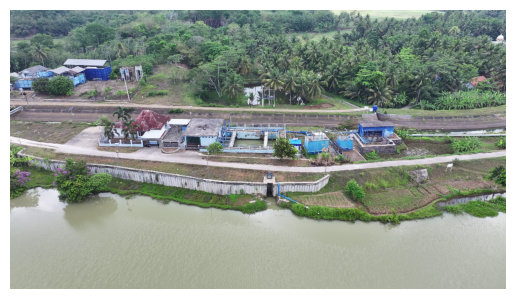

In [23]:
video_path = "./data/DJI_20241025100421_0057_D.MP4"

# Load first frame
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()

# Resize to HD resolution
frame = cv2.resize(frame, (1280, 720))

frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
cap.release()

plt.imshow(frame)
plt.axis("off")
plt.show()

In [8]:
# tracker = sv.ByteTrack(track_activation_threshold=0.10)

In [9]:
def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters:
    - box1, box2: tuples or lists containing bounding box coordinates in the format (xmin, ymin, xmax, ymax)

    Returns:
    - iou: float, the IoU between box1 and box2
    """
    # Unpack coordinates for both boxes
    xmin1, ymin1, xmax1, ymax1 = box1
    xmin2, ymin2, xmax2, ymax2 = box2

    # Calculate the intersection coordinates
    x_inter_min = max(xmin1, xmin2)
    y_inter_min = max(ymin1, ymin2)
    x_inter_max = min(xmax1, xmax2)
    y_inter_max = min(ymax1, ymax2)

    # Calculate the area of the intersection
    inter_width = max(0, x_inter_max - x_inter_min)
    inter_height = max(0, y_inter_max - y_inter_min)
    inter_area = inter_width * inter_height

    # Calculate the area of both bounding boxes
    area_box1 = (xmax1 - xmin1) * (ymax1 - ymin1)
    area_box2 = (xmax2 - xmin2) * (ymax2 - ymin2)

    # Calculate the union area
    union_area = area_box1 + area_box2 - inter_area

    # Calculate the IoU
    iou = inter_area / union_area if union_area > 0 else 0

    return iou

In [10]:
def non_max_suppression(predictions_boxes, scores, iou_threshold=0.5):
    """
    Perform Non-Maximum Suppression (NMS) on the bounding boxes.
    Returns the indices of the boxes that should be kept.

    Parameters:
    - predictions_boxes: list of tuples or lists containing bounding box coordinates in the format (xmin, ymin, xmax, ymax)
    - scores: list of floats, the confidence scores for each bounding box
    - iou_threshold: float, the IoU threshold for NMS

    Returns:
    - indices: list of integers, the indices of the bounding boxes that should be kept
    """

    # Sort the bounding boxes by their confidence scores
    sorted_indices = np.argsort(scores)[::-1]

    # Initialize the list of indices to keep
    indices = []

    while len(sorted_indices) > 0:
        # Keep the box with the highest confidence score
        indices.append(sorted_indices[0])

        # Calculate the IoU of the first box with all other boxes
        iou = np.array([calculate_iou(predictions_boxes[sorted_indices[0]], predictions_boxes[i]) for i in sorted_indices[1:]])

        # Find the indices of boxes with IoU less than the threshold and remove them
        filtered_indices = np.where(iou <= iou_threshold)[0]
        sorted_indices = sorted_indices[filtered_indices + 1]

    return indices


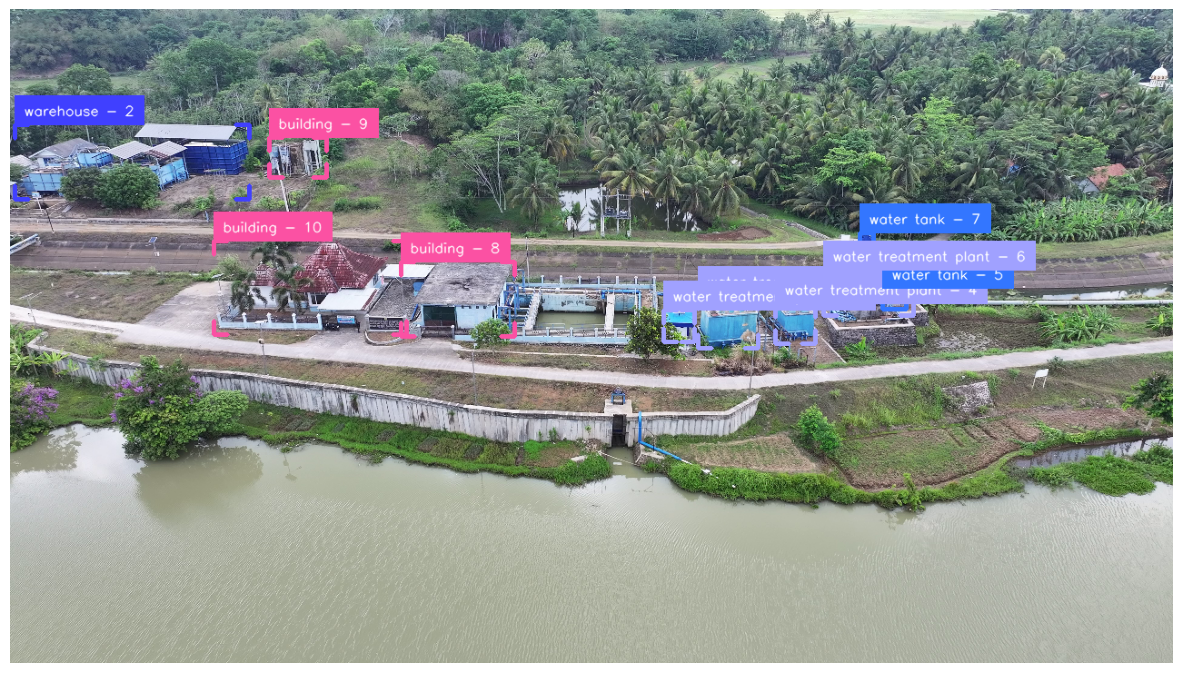

In [ ]:
# Predict the bounding boxes using OWL-V2
labels = ["building", "warehouse", "water treatment plant", "water tank"]
prompts = [labels]

detections = query_detection(prompts, frame, threshold=0.2)
keep_idx = non_max_suppression(detections.xyxy, detections.confidence, iou_threshold=0.15)
detections = detections[keep_idx]

# detections = tracker.update_with_detections(detections)
detections.tracker_id = np.arange(len(detections)) + 1

corner_annotator = sv.BoxCornerAnnotator()
label_annotator = sv.LabelAnnotator()
annotated_frame = corner_annotator.annotate(
    scene=frame.copy(),
    detections=detections
)

annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections,
    labels=[f"{labels[idx]} - {tracker_id}" for idx, tracker_id in zip(detections.class_id, detections.tracker_id)]
    # labels=[f"{labels[idx]}" for idx in ÷detections.class_id]
    
)
fig = plt.figure(figsize=(15, 10))
plt.imshow(annotated_frame)
plt.axis("off")
plt.show()

In [12]:
# visual_query_path = "./visual_query/"
# visual_query_images = [
#     Image.open(os.path.join(visual_query_path, img_path)).convert("RGB")
#     for img_path in os.listdir(visual_query_path)
# ]

# # Plot the visual query images
# fig, axes = plt.subplots(1, len(visual_query_images), figsize=(20, 10))
# for ax, img in zip(axes, visual_query_images):
#     ax.imshow(img)
#     ax.axis("off")
# plt.show()

# query_pixel_values = processor(query_images=visual_query_images, return_tensors="pt")["query_pixel_values"]
# query_pixel_values.shape

# visual_labels = {id: label.split(".")[0] for id, label in enumerate(os.listdir(visual_query_path))}
# visual_labels

In [16]:
# # Predict the bounding boxes using OWL-V2
# labels = ["building", "water tank"]
# prompts = [labels]

# # detections = visual_query_detection(visual_query_images, frame, threshold=0.2)

# inputs = processor(images=frame, query_images=visual_query_images[0], return_tensors="pt")

# with torch.no_grad():
#     outputs = model.image_guided_detection(**inputs)

# # Target image sizes (height, width) to rescale box predictions [batch_size, 2]
# target_sizes = torch.Tensor([frame.shape[:2]]).repeat(1, 1)

# # Convert outputs (bounding boxes and class logits) to Pascal VOC Format (xmin, ymin, xmax, ymax)
# results = processor.post_process_image_guided_detection(
#     outputs=outputs, target_sizes=target_sizes, threshold=0.9
# )

# detections = sv.Detections(
#     xyxy=results[0]['boxes'].cpu().numpy(),
#     confidence=results[0]['scores'].cpu().numpy(),
#     class_id=results[0]['labels']
# )

# keep_idx = non_max_suppression(detections.xyxy, detections.confidence, iou_threshold=0.25)

# detections = detections[keep_idx]


# # detections = tracker.update_with_detections(detections)
# detections.tracker_id = np.arange(len(detections)) + 1

# corner_annotator = sv.BoxCornerAnnotator(color_lookup=sv.ColorLookup.TRACK)
# label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.TRACK)
# annotated_frame = corner_annotator.annotate(
#     scene=frame.copy(),
#     detections=detections
# )

# annotated_frame = label_annotator.annotate(
#     scene=annotated_frame,
#     detections=detections,
#     labels=[f"{tracker_id}" for tracker_id in detections.tracker_id]
#     # labels=[f"{labels[idx]}" for idx in ÷detections.class_id]
    
# )
# fig = plt.figure(figsize=(15, 10))
# plt.imshow(annotated_frame)
# plt.axis("off")
# plt.show()

In [17]:
def detection_from_segmentation(detections, out_obj_ids, out_mask_logits):
    tracker_id_to_obj_id = {detections.tracker_id[i]: i for i in range(len(detections))}

    # Update the mask for each detection
    out_masks = out_mask_logits[:, 0, ...].cpu().numpy() > 0.0
    total_area = np.sum(out_masks, axis=(1, 2))

    # Filter out masks with area less than 50
    out_masks = out_masks[total_area > 50]

    detections.mask = np.zeros(
        (len(detections), out_masks.shape[1], out_masks.shape[2]), dtype=bool
    )

    segmentation_bbox = masks_to_boxes(torch.tensor(out_masks).float()).numpy()

    valid_detections = []

    for obj_id, object_mask in zip(out_obj_ids, out_masks):
        if obj_id not in tracker_id_to_obj_id:
            continue
        detection_idx = tracker_id_to_obj_id[obj_id]
        
        if detection_idx >= len(detections):
            continue

        valid_detections.append(detection_idx)

        # Update detection with the mask
        detections.mask[detection_idx] = object_mask

        # Update detection with the segmentation bbox
        detections.xyxy[detection_idx] = segmentation_bbox[detection_idx]

    return detections[valid_detections]

In [25]:
corner_annotator = sv.BoxCornerAnnotator(color_lookup=sv.ColorLookup.CLASS)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.CLASS)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.CLASS)

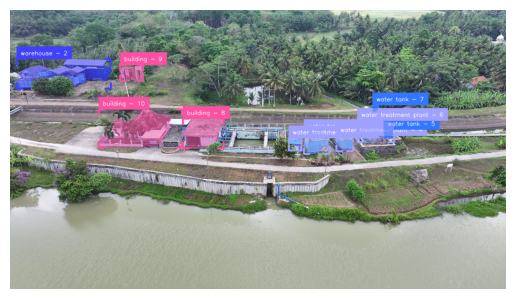

In [26]:
# Add first frame to sam2 predictor
predictor.load_first_frame(frame)
ann_frame_idx = 0

for ann_obj_id in range(len(detections)):
    box = detections.xyxy[ann_obj_id]
    bbox = np.array([box[:2], box[2:]])
    _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(
        frame_idx=ann_frame_idx, obj_id=detections.tracker_id[ann_obj_id], bbox=bbox
    )

detections = detection_from_segmentation(detections, out_obj_ids, out_mask_logits)

annotated_frame = corner_annotator.annotate(scene=frame.copy(), detections=detections)

annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections,
    labels=[
        f"{labels[idx]} - {tracker_id}"
        for idx, tracker_id in zip(detections.class_id, detections.tracker_id)
    ],
)

annotated_frame = mask_annotator.annotate(
    scene=annotated_frame,
    detections=detections
)

plt.imshow(annotated_frame)
plt.axis("off")
plt.show()

In [27]:
output_dir = "./outputs/"
os.makedirs(output_dir, exist_ok=True)

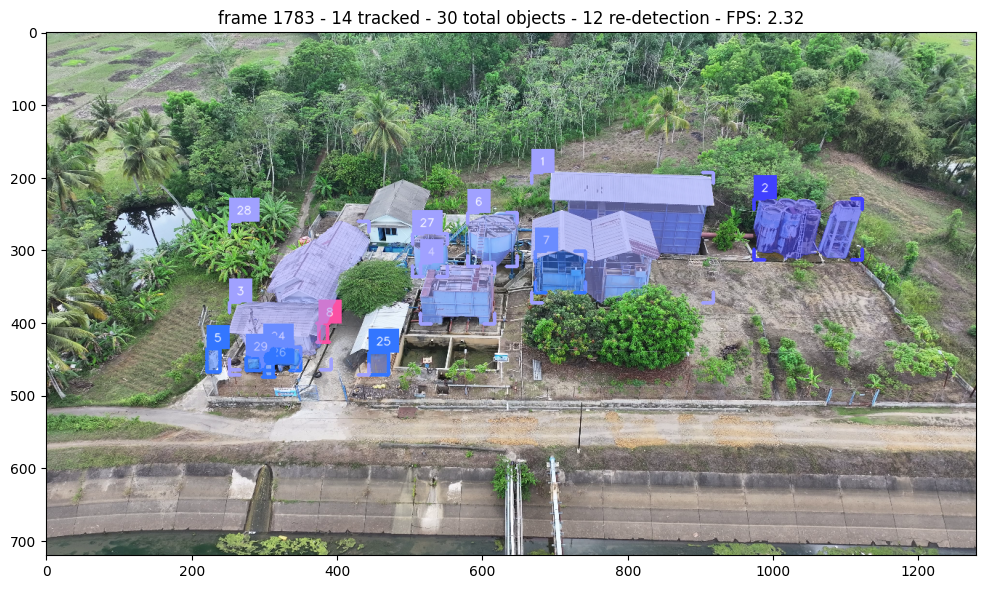

In [29]:
import time

# Predict the bounding boxes using OWL-V2
# labels = ["administrative building", "building", "warehouse", "office", "water treatment plant"]
labels = ["building", "warehouse", "water treatment plant", "water tank"]

prompts = [labels]

redetect_interval = 150
max_id = 0

# tracker = sv.ByteTrack(track_activation_threshold=0.05)
total_new_detected = 0

# Calculate FPS
start_time = time.time()

try:
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, (1280, 720))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        width, height = frame.shape[:2][::-1]

        if frame_idx == 0:
            predictor.reset_state()
            predictor.load_first_frame(frame)

            detections = query_detection(prompts, frame, threshold=0.2)
            keep_idx = non_max_suppression(detections.xyxy, detections.confidence, iou_threshold=0.15)

            detections = detections[keep_idx]
            total_new_detected = len(detections)
            detections.tracker_id = np.arange(0, len(detections)) + max_id + 1

            for ann_obj_id in range(len(detections)):
                box = detections.xyxy[ann_obj_id]
                obj_id = detections.tracker_id[ann_obj_id]
                bbox = np.array([box[:2], box[2:]])
                _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(
                    frame_idx=0, obj_id=obj_id, bbox=bbox
                )

            detections = detection_from_segmentation(
                detections, out_obj_ids, out_mask_logits
            )
            max_id = max(max_id, detections.tracker_id.max())

        elif frame_idx != 0 and frame_idx % redetect_interval == 0:
            new_detections = query_detection(prompts, frame, threshold=0.2)
            keep_idx = non_max_suppression(new_detections.xyxy, new_detections.confidence, iou_threshold=0.15)

            new_detections = new_detections[keep_idx]

            total_new_detected = len(new_detections)
            valid_new_detection_idx = []

            # Add new detections if the IoU is less than 0.125
            for new_det_idx in range(len(new_detections)):
                new_det = new_detections.xyxy[new_det_idx]

                ious = [calculate_iou(new_det, det) for det in detections.xyxy]
                if all(iou < 0.125 for iou in ious):
                    valid_new_detection_idx.append(new_det_idx)

            new_detections = new_detections[valid_new_detection_idx]
            new_detections.mask = np.zeros(
                (len(new_detections), frame.shape[0], frame.shape[1]), dtype=bool
            )

            if len(new_detections) > 0:
                new_detections.tracker_id = np.arange(0, len(new_detections)) + max_id + 1

                detections = sv.Detections.merge([detections, new_detections])

                predictor.reset_state()
                predictor.load_first_frame(frame)

                for ann_obj_id in range(len(detections)):
                    box = detections.xyxy[ann_obj_id]
                    obj_id = detections.tracker_id[ann_obj_id]
                    bbox = np.array([box[:2], box[2:]])
                    _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(
                        frame_idx=0, obj_id=obj_id, bbox=bbox
                    )

                detections = detection_from_segmentation(
                    detections, out_obj_ids, out_mask_logits
                )

                max_id = max(max_id, detections.tracker_id.max())

        else:
            out_obj_ids, out_mask_logits = predictor.track(frame)
            detections = detection_from_segmentation(
                detections, out_obj_ids, out_mask_logits
            )

        # Cut out each detection

        annotated_frame = corner_annotator.annotate(
            scene=frame.copy(), detections=detections
        )

        annotated_frame = label_annotator.annotate(
            scene=annotated_frame,
            detections=detections,
            labels=[
                f"{tracker_id}"
                for idx, tracker_id in zip(detections.class_id, detections.tracker_id)
            ],
        )

        annotated_frame = mask_annotator.annotate(
            scene=annotated_frame, detections=detections
        )

        current_time = time.time()
        fps = (frame_idx + 1) / (current_time - start_time)

        display.clear_output(wait=True)
        plt.figure(figsize=(12, 8))
        plt.title(
            f"frame {frame_idx} - {len(detections)} tracked - {max_id + 1} total objects - {total_new_detected} re-detection - FPS: {fps:.2f}"
        )
        plt.imshow(annotated_frame)
        plt.show()

        # Save the annotated frame
        output_path = os.path.join(output_dir, f"frame_{str(frame_idx).zfill(5)}.png")
        cv2.imwrite(output_path, cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR))

        frame_idx += 1

finally:
    cap.release()

In [ ]:
from tqdm import tqdm

# Save the annotated video with opencv
output_video_path = "annotated_video_raw.mp4"
frame_paths = sorted([os.path.join(output_dir, image_name) for image_name in os.listdir(output_dir)])

frame = cv2.imread(frame_paths[0])
height, width, _ = frame.shape

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video_writer = cv2.VideoWriter(output_video_path, fourcc, 30, (width, height))

for frame_path in tqdm(frame_paths):
    frame = cv2.imread(frame_path)
    video_writer.write(frame)

video_writer.release()

  9%|▉         | 74/810 [00:01<00:11, 61.82it/s]

100%|██████████| 810/810 [00:12<00:00, 62.45it/s]


In [ ]:
from torchvision.ops import masks_to_boxes

masks_to_boxes(out_mask_logits[:, 0, ...] > 0.0)

tensor([[ 22., 117., 136., 168.],
        [356., 125., 421., 185.],
        [445., 151., 541., 220.],
        [334., 157., 402., 261.]], device='cuda:0')

In [ ]:
# Add first frame to sam2 predictor
predictor.load_first_frame(image)
ann_frame_idx = 0

